### Authors: </br>
Ruy Guzmán </br>
Fernanda de León </br>
Karla Mondragón

# LSTM

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Dataset Overview

In [2]:
df_msft = pd.read_csv('../database/ticker_MSFT.csv')
df_goog = pd.read_csv('../database/ticker_GOOG.csv')
df_v = pd.read_csv('../database/ticker_V.csv')

In [3]:
df_v["Date"] = pd.to_datetime(df_v.Date)
df_v = df_v.set_index("Date")
df_v

,Open,High,Low,Close,Adj Close,Volume,Symbol
Date,,,,,,,
2021-12-06,198.770004,204.220001,197.740005,202.679993,199.573517,10722100,V
2021-12-07,206.000000,207.940002,205.889999,207.369995,204.191650,11897200,V
2021-12-08,207.660004,209.479996,205.710007,208.990005,205.786804,11749200,V
2021-12-09,208.520004,212.199997,207.169998,211.389999,208.150009,10176800,V
2021-12-10,211.899994,214.250000,210.860001,213.399994,210.129211,8882700,V
...,...,...,...,...,...,...,...
2023-11-29,253.919998,256.070007,253.520004,254.229996,254.229996,4955100,V
2023-11-30,254.250000,256.769989,253.169998,256.679993,256.679993,6874700,V
2023-12-01,255.789993,256.910004,253.899994,256.450012,256.450012,3939400,V


In [4]:
def plotVariables(df,vars, title):
    df[vars].plot(
        figsize=(15,7), 
        title=title,
        subplots = True
    )

    plt.show()

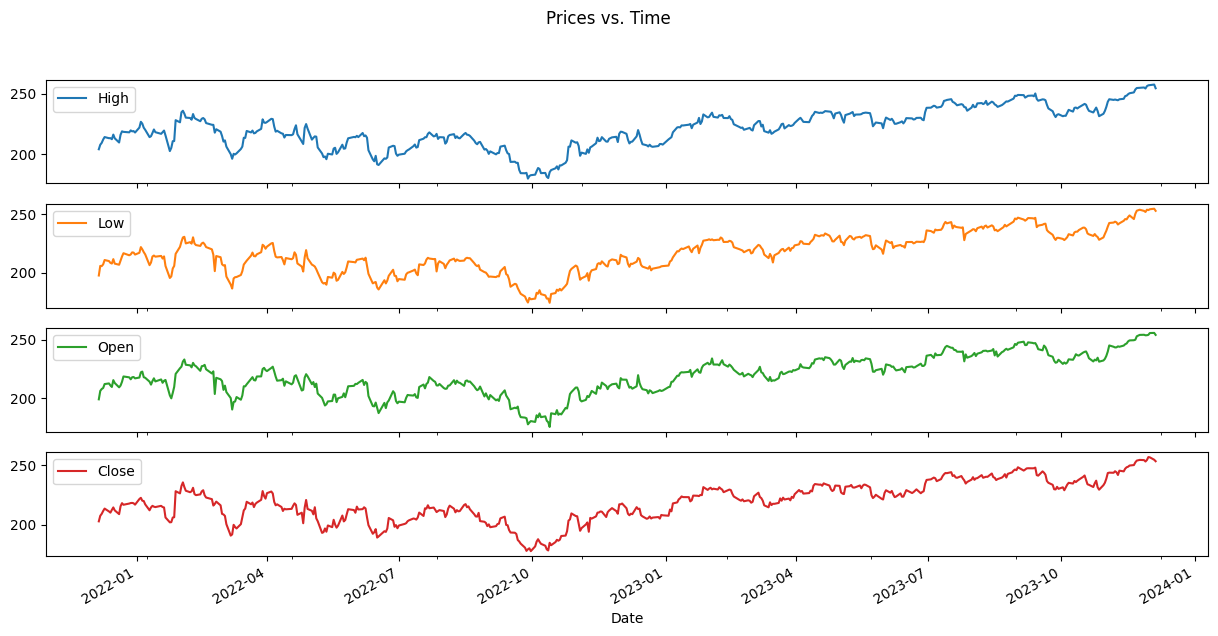

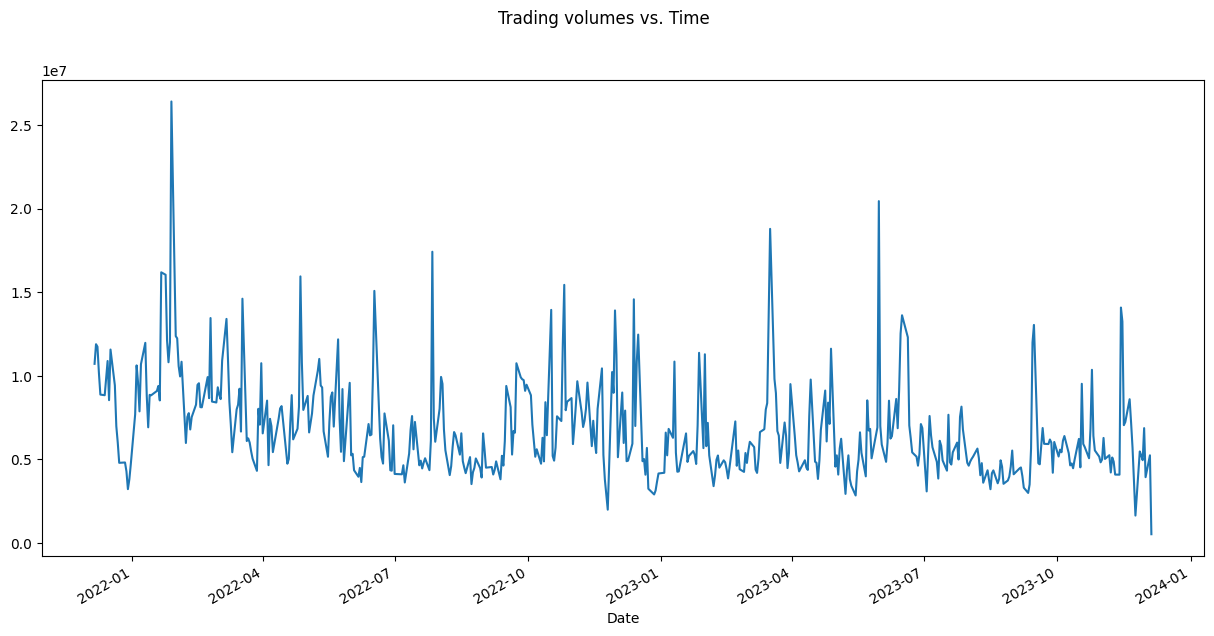

In [5]:
plotVariables(df_v,['High','Low','Open','Close'],'Prices vs. Time')
plotVariables(df_v,'Volume','Trading volumes vs. Time')

In [6]:
df_v = df_v.drop(columns=['Open','High','Low'])
df_v

,Close,Adj Close,Volume,Symbol
Date,,,,
2021-12-06,202.679993,199.573517,10722100,V
2021-12-07,207.369995,204.191650,11897200,V
2021-12-08,208.990005,205.786804,11749200,V
2021-12-09,211.389999,208.150009,10176800,V
2021-12-10,213.399994,210.129211,8882700,V
...,...,...,...,...
2023-11-29,254.229996,254.229996,4955100,V
2023-11-30,256.679993,256.679993,6874700,V
2023-12-01,256.450012,256.450012,3939400,V


## Data Preprocessing

In [7]:
traininig_data = df_v.loc[df_v.index < '2023-01-01']

In [8]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(traininig_data['Close'].values.reshape(-1,1))
scaled_data

array([[0.43326981],
       [0.51445385],
       [0.54249627],
       [0.58404021],
       [0.61883326],
       [0.57763559],
       [0.55963302],
       [0.5999654 ],
       [0.635624  ],
       [0.59252222],
       [0.53816876],
       [0.65310729],
       [0.69776718],
       [0.67457155],
       [0.69205484],
       [0.69932502],
       [0.70140213],
       [0.69620907],
       [0.67612965],
       [0.75783271],
       [0.77566227],
       [0.7330795 ],
       [0.728752  ],
       [0.68045716],
       [0.59408006],
       [0.63579727],
       [0.65881963],
       [0.6465294 ],
       [0.64081706],
       [0.65881963],
       [0.64099006],
       [0.63527799],
       [0.48952738],
       [0.41890272],
       [0.42149912],
       [0.48848882],
       [0.4933356 ],
       [0.87155967],
       [0.8398823 ],
       [0.94703138],
       [1.        ],
       [0.93283703],
       [0.87831057],
       [0.85701932],
       [0.87052112],
       [0.92123935],
       [0.82984246],
       [0.814

In [9]:
# Set the number of days used for prediction
prediction_days = 25

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [10]:
def LSTM_model():
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))
    # Add a second LSTM layer with 50 units and return sequences
    model.add(LSTM(units=50, return_sequences=True))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=50))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

## Training

In [11]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam', 
    loss='mean_squared_error'
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 25, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 25, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 25, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 25, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 

In [12]:
# Define callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5', 
    verbose = 2, 
    save_best_only = True
)

model.fit(
    x_train, 
    y_train, 
    epochs=25, 
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/25

8/8 [==============================] - 5s 30ms/step - loss: 0.1726
Epoch 2/25
8/8 [==============================] - 0s 28ms/step - loss: 0.0506
Epoch 3/25
8/8 [==============================] - 0s 31ms/step - loss: 0.0462
Epoch 4/25
8/8 [==============================] - 0s 28ms/step - loss: 0.0353
Epoch 5/25
8/8 [==============================] - 0s 30ms/step - loss: 0.0322
Epoch 6/25
8/8 [==============================] - 0s 27ms/step - loss: 0.0312
Epoch 7/25
8/8 [==============================] - 0s 28ms/step - loss: 0.0290
Epoch 8/25
8/8 [==============================] - 0s 27ms/step - loss: 0.0287
Epoch 9/25
8/8 [==============================] - 0s 27ms/step - loss: 0.0280
Epoch 10/25
8/8 [==============================] - 0s 29ms/step - loss: 0.0288
Epoch 11/25
8/8 [==============================] - 0s 27ms/step - loss: 0.0284
Epoch 12/25
8/8 [==============================] - 0s 32ms/step - loss: 0.0274
Epoch 13/25
8/8 [==============================] - 0s 28ms/s

## Inference

In [13]:
test_data = df_v.loc[df_v.index >= '2023-01-01']

In [14]:
# Extract the actual closing prices from the test data
actual_prices = test_data['Close'].values

# Concatenate the training and test data along the 'Close' column
total_dataset = pd.concat((df_v['Close'], test_data['Close']), axis=0)

# Extract the relevant portion of the dataset for model inputs
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
model_inputs = model_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
model_inputs = scaler.transform(model_inputs)

In [15]:
x_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(model_inputs)):
    # Append the previous 'prediction_days' values to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])

# Convert the x_test list to a numpy array
x_test = np.array(x_test)
print("Before reshaping:", x_test.shape)

Before reshaping: (233, 25)


In [16]:
# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print("After reshaping:", x_test.shape)

# Generate price predictions using the LSTM model
predicted_prices = model.predict(x_test)

# Invert the scaling applied to the predicted prices to obtain actual values
predicted_prices = scaler.inverse_transform(predicted_prices)

After reshaping: (233, 25, 1)
8/8 [==============================] - 1s 10ms/step


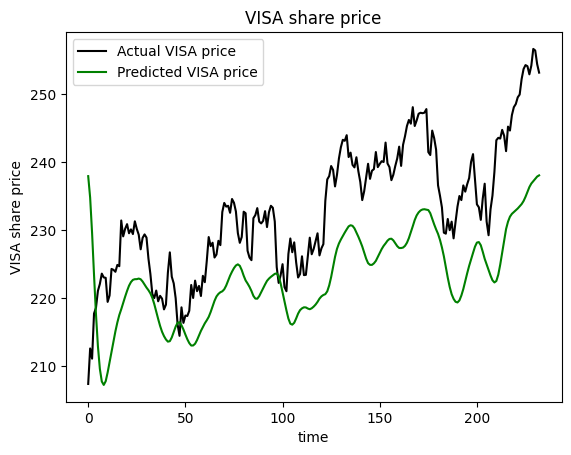

In [18]:
COMPANY = "VISA"

# Plot the actual prices using a black line
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price")

# Plot the predicted prices using a green line
plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price")

# Set the title of the plot using the company name
plt.title(f"{COMPANY} share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel(f"{COMPANY} share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

# Show the plot on the screen
plt.show()

In [21]:
# TODO: Corregir a que sea si sube o baja
# TODO: índice de accuracy

In [19]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction: 237.65640258789062
